In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from finta import TA


In [2]:
alpaca_api_key = 'ALPACA_API_KEY'
alpaca_secret_key = 'ALPACA_SECRET_KEY'
alpaca_api_base_url = "https://paper-api.alpaca.markets"
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


In [3]:
# Set the ticker
ticker = "SPY"

# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes of 5 years
start_date = pd.Timestamp("2019-01-02", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2024-01-02", tz="America/New_York").isoformat()

# Get 5 years worth of historical data for SPY
ticker_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df
ticker_data.head()

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2019-01-02 05:00:00+00:00,250.23,251.21,245.95,603603,245.98,132165224,249.138858
2019-01-03 05:00:00+00:00,244.15,248.57,243.67,698036,248.23,146823673,245.630167
2019-01-04 05:00:00+00:00,252.39,253.11,247.17,708230,247.59,145055352,250.484620
2019-01-07 05:00:00+00:00,254.29,255.95,251.69,449993,252.69,105208591,254.071648
2019-01-08 05:00:00+00:00,256.62,257.31,254.00,461969,256.82,103624383,255.859713


In [4]:
# Filter the date index and close columns
signals_df = ticker_data.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
timestamp,,
2019-01-03 05:00:00+00:00,244.15,-0.024298
2019-01-04 05:00:00+00:00,252.39,0.033750
2019-01-07 05:00:00+00:00,254.29,0.007528
2019-01-08 05:00:00+00:00,256.62,0.009163
2019-01-09 05:00:00+00:00,257.92,0.005066


,close,Actual Returns
timestamp,,
2023-12-26 05:00:00+00:00,475.65,0.004223
2023-12-27 05:00:00+00:00,476.51,0.001808
2023-12-28 05:00:00+00:00,476.69,0.000378
2023-12-29 05:00:00+00:00,475.31,-0.002895
2024-01-02 05:00:00+00:00,472.65,-0.005596


In [5]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

/var/folders/df/dc921sk53tlchld3cqvkhkjw0000gn/T/ipykernel_72707/1940832839.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ohlcv_df = pd.read_csv(
/var/folders/df/dc921sk53tlchld3cqvkhkjw0000gn/T/ipykernel_72707/1940832839.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ohlcv_df = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [6]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


In [7]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['EMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['EMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,EMA_Fast,EMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,EMA_Fast,EMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [8]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,EMA_Fast,EMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,EMA_Fast,EMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [9]:
signals_df['Signal'].value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

In [10]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,EMA_Fast,EMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,EMA_Fast,EMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<Axes: xlabel='date'>

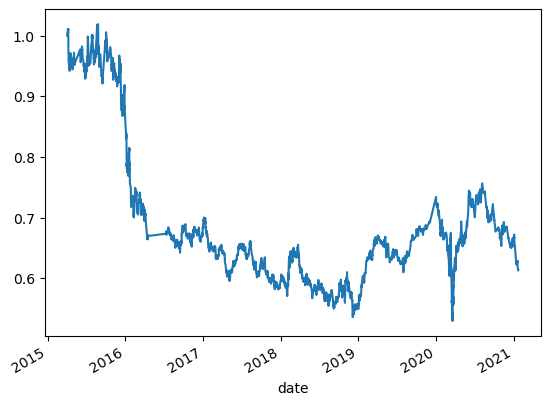

In [11]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [12]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['EMA_Fast', 'EMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,EMA_Fast,EMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [13]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

In [14]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,EMA_Fast,EMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,EMA_Fast,EMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [18]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred


array([1., 1., 1., ..., 1., 1., 1.])

In [20]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



In [21]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df['Actual Returns'] * predictions_df['Predicted']
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [22]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot()


:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [23]:
# Import a new classifier from SKLearn
from sklearn.tree import DecisionTreeClassifier

# Initiate the model instance
dtc_model = DecisionTreeClassifier()

In [24]:
# Fit the model using the training data
dtc_model = dtc_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
dtc_pred = dtc_model.predict(X_test_scaled)

# Review the model's predicted values
dtc_pred


array([ 1., -1., -1., ..., -1., -1., -1.])

In [25]:
# Use a classification report to evaluate the model using the predictions and testing data
dtc_testing_report = classification_report(y_test, dtc_pred)

# Print the classification report
print(dtc_testing_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.92      0.60      1804
         1.0       0.57      0.09      0.15      2288

    accuracy                           0.45      4092
   macro avg       0.51      0.50      0.37      4092
weighted avg       0.51      0.45      0.35      4092



In [26]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
dtc_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
dtc_predictions_df['DTC Predicted'] = dtc_pred

# Add the actual returns to the DataFrame
dtc_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
dtc_predictions_df['DTC Strategy Returns'] = (
    dtc_predictions_df['Actual Returns'] * dtc_predictions_df['DTC Predicted']
)

# Review the DataFrame
display(dtc_predictions_df.head())
display(dtc_predictions_df.tail())

,DTC Predicted,Actual Returns,DTC Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,-1.0,0.007237,-0.007237
2015-07-06 14:15:00,-1.0,-0.009721,0.009721
2015-07-06 14:30:00,-1.0,-0.003841,0.003841
2015-07-07 11:30:00,-1.0,-0.018423,0.018423


,DTC Predicted,Actual Returns,DTC Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


In [27]:
# Plot the actual returns versus the strategy returns
(1 + dtc_predictions_df[['Actual Returns', 'DTC Strategy Returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [28]:
# instantiate the DecisionTreeClassifier model with criterion gini index

dtc_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
dtc_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [29]:
y_pred_gini = dtc_gini.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.4648


In [31]:
y_pred_train_gini = dtc_gini.predict(X_train)

y_pred_train_gini

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.])

In [32]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.7344


In [33]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(dtc_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(dtc_gini.score(X_test, y_test)))

Training set score: 0.7344
Test set score: 0.4648


In [34]:
# instantiate the DecisionTreeClassifier model with criterion entropy

dtc_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
dtc_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [35]:
y_pred_en = dtc_en.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.4636


In [37]:
y_pred_train_en = dtc_en.predict(X_train)

y_pred_train_en

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.])

In [38]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.7344


In [39]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(dtc_en.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(dtc_en.score(X_test, y_test)))

Training set score: 0.7344
Test set score: 0.4636


Confusion matrix

 [[1379  425]
 [1770  518]]


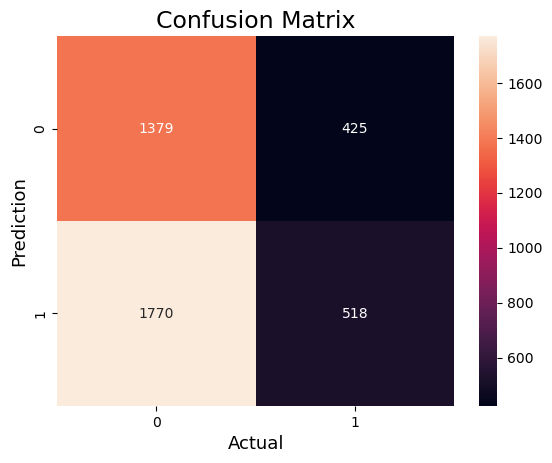

Accuracy   : 0.46358748778103614


In [52]:
import seaborn as sns
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_en)

print('Confusion matrix\n\n', cm)

sns.heatmap(cm, 
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()



accuracy = accuracy_score(y_test, y_pred_en)
print("Accuracy   :", accuracy)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

        -1.0       0.44      0.76      0.56      1804
         1.0       0.55      0.23      0.32      2288

    accuracy                           0.46      4092
   macro avg       0.49      0.50      0.44      4092
weighted avg       0.50      0.46      0.42      4092



In [54]:
# Create a predictions DataFrame
pred_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
pred_df['New Predicted'] = dtc_pred

# Add the actual returns to the DataFrame
pred_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
pred_df['New Strategy Returns'] = (pred_df['Actual Returns'] * pred_df['New Predicted'])

# Review the DataFrame
display(pred_df.head())
display(pred_df.tail())

,New Predicted,Actual Returns,New Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,-1.0,0.007237,-0.007237
2015-07-06 14:15:00,-1.0,-0.009721,0.009721
2015-07-06 14:30:00,-1.0,-0.003841,0.003841
2015-07-07 11:30:00,-1.0,-0.018423,0.018423


,New Predicted,Actual Returns,New Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


In [55]:
# Plot the actual returns versus the strategy returns
(1 + pred_df[['Actual Returns', 'New Strategy Returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [56]:
# Create a list for the column name
columns = ["Actual"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
spy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [57]:
 # Calculate annualized return
spy_evaluation_df.loc["Annualized Return"] = (
    pred_df["Actual Returns"].mean() * 252
)

# Calculate cumulative return
spy_evaluation_df.loc["Cumulative Returns"] = (1 + pred_df["Actual Returns"]).cumprod()[-1]

 # Calculate annual volatility
spy_evaluation_df.loc["Annual Volatility"] = (
    pred_df["Actual Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
spy_evaluation_df.loc["Sharpe Ratio"] = (
    pred_df["Actual Returns"].mean() * 252) / (
    pred_df["Actual Returns"].std() * np.sqrt(252)
)

# Review the result
spy_evaluation_df

,Actual
Annualized Return,0.025777
Cumulative Returns,1.386976
Annual Volatility,0.105992
Sharpe Ratio,0.243199


In [58]:
# Create a list for the column name
columns = ["Strategy"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
strategy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [59]:
 # Calculate annualized return
strategy_evaluation_df.loc["Annualized Return"] = (
    pred_df["New Strategy Returns"].mean() * 252
)

# Calculate cumulative return
strategy_evaluation_df.loc["Cumulative Returns"] = (1 + pred_df["New Strategy Returns"]).cumprod()[-1]

 # Calculate annual volatility
strategy_evaluation_df.loc["Annual Volatility"] = (
    pred_df["New Strategy Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
strategy_evaluation_df.loc["Sharpe Ratio"] = (
    pred_df["New Strategy Returns"].mean() * 252) / (
    pred_df["New Strategy Returns"].std() * np.sqrt(252)
)

# Review the result
strategy_evaluation_df

,Strategy
Annualized Return,-0.023122
Cumulative Returns,0.627191
Annual Volatility,0.105994
Sharpe Ratio,-0.218141


In [60]:
pd.concat([spy_evaluation_df, strategy_evaluation_df], axis=1)

,Actual,Strategy
Annualized Return,0.025777,-0.023122
Cumulative Returns,1.386976,0.627191
Annual Volatility,0.105992,0.105994
Sharpe Ratio,0.243199,-0.218141
